Processing worlds-largest-selfie.jpg at scale 0.2500
Processing worlds-largest-selfie.jpg at scale 0.5000
Processing worlds-largest-selfie.jpg at scale 0.7500
Processing worlds-largest-selfie.jpg at scale 1.0000
Processing worlds-largest-selfie.jpg at scale 1.2500
Processing worlds-largest-selfie.jpg at scale 1.5000
Processing worlds-largest-selfie.jpg at scale 1.7600
Processing worlds-largest-selfie.jpg at scale 2.0000
Processing worlds-largest-selfie.jpg at scale 2.1000
Processing worlds-largest-selfie.jpg at scale 2.2000
time 274.29 secs for worlds-largest-selfie.jpg
Found 95 Person


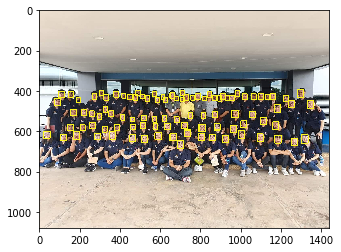

In [6]:
# -*- coding: utf-8 -*-
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
import tiny_face_model
import util
from argparse import ArgumentParser
import cv2
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import pickle

import pylab as pl
import time
import os
import sys
from scipy.special import expit
import glob

MAX_INPUT_DIM = 5000.0

def overlay_bounding_boxes(raw_img, refined_bboxes, lw):
  """Overlay bounding boxes of face on images.
    Args:
      raw_img:
        A target image.
      refined_bboxes:
        Bounding boxes of detected faces.
      lw: 
        Line width of bounding boxes. If zero specified,
        this is determined based on confidence of each detection.
    Returns:
      None.
  """

  # Overlay bounding boxes on an image with the color based on the confidence.
  for r in refined_bboxes:
    _score = expit(r[4])
    cm_idx = int(np.ceil(_score * 255))
    rect_color = [int(np.ceil(x * 255)) for x in util.cm_data[cm_idx]]  # parula
    _lw = lw
    if lw == 0:  # line width of each bounding box is adaptively determined.
      bw, bh = r[2] - r[0] + 1, r[3] - r[0] + 1
      _lw = 1 if min(bw, bh) <= 20 else max(2, min(3, min(bh / 20, bw / 20)))
      _lw = int(np.ceil(_lw * _score))

    _r = [int(x) for x in r[:4]]
    cv2.rectangle(raw_img, (_r[0], _r[1]), (_r[2], _r[3]), rect_color, _lw)
    
    
def evaluate(weight_file_path, data_dir, output_dir, prob_thresh=0.5, nms_thresh=0.1, lw=3, display=False):
  """Detect faces in images.
  Args:
    prob_thresh:
        The threshold of detection confidence.
    nms_thresh:
        The overlap threshold of non maximum suppression
    weight_file_path: 
        A pretrained weight file in the pickle format 
        generated by matconvnet_hr101_to_tf.py.
    data_dir: 
        A directory which contains images.
    output_dir: 
        A directory into which images with detected faces are output.
    lw: 
        Line width of bounding boxes. If zero specified,
        this is determined based on confidence of each detection.
    display:
        Display tiny face images on window.
  Returns:
    None.
  """

  # placeholder of input images. Currently batch size of one is supported.
  x = tf.placeholder(tf.float32, [1, None, None, 3]) # n, h, w, c

  # Create the tiny face model which weights are loaded from a pretrained model.
  model = tiny_face_model.Model(weight_file_path)
  score_final = model.tiny_face(x)

  # Find image files in data_dir.
  filenames = []
  for ext in ('*.png', '*.gif', '*.jpg', '*.jpeg'):
    filenames.extend(glob.glob(os.path.join(data_dir, ext)))

  # Load an average image and clusters(reference boxes of templates).
  with open(weight_file_path, "rb") as f:
    _, mat_params_dict = pickle.load(f)

  average_image = model.get_data_by_key("average_image")
  clusters = model.get_data_by_key("clusters")
  clusters_h = clusters[:, 3] - clusters[:, 1] + 1
  clusters_w = clusters[:, 2] - clusters[:, 0] + 1
  normal_idx = np.where(clusters[:, 4] == 1)

  # main
  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for filename in filenames:
      fname = filename.split(os.sep)[-1]
      raw_img = cv2.imread(filename)
      raw_img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB)
      raw_img_f = raw_img.astype(np.float32)

      def _calc_scales():
        raw_h, raw_w = raw_img.shape[0], raw_img.shape[1]
        min_scale = min(np.floor(np.log2(np.max(clusters_w[normal_idx] / raw_w))),
                        np.floor(np.log2(np.max(clusters_h[normal_idx] / raw_h))))
        max_scale = min(1.0, -np.log2(max(raw_h, raw_w) / MAX_INPUT_DIM))
        scales_down = pl.frange(min_scale, 0, 1.)
        scales_up = pl.frange(0.5, max_scale, 0.5)
        scales_pow = np.hstack((scales_down, scales_up))
        scales = np.power(2.0, scales_pow)
        return scales

      # scales = _calc_scales()
      scales = [0.25,0.5,0.75,1.0,1.25,1.5,1.76,2.0,2.1,2.2]
      start = time.time()

      # initialize output
      bboxes = np.empty(shape=(0, 5))

      # process input at different scales
      for s in scales:
        print("Processing {} at scale {:.4f}".format(fname, s))
        img = cv2.resize(raw_img_f, (0, 0), fx=s, fy=s, interpolation=cv2.INTER_LINEAR)
        img = img - average_image
        img = img[np.newaxis, :]

        # we don't run every template on every scale ids of templates to ignore
        tids = list(range(4, 12)) + ([] if s <= 1.0 else list(range(18, 25)))
        ignoredTids = list(set(range(0, clusters.shape[0])) - set(tids))

        # run through the net
        score_final_tf = sess.run(score_final, feed_dict={x: img})

        # collect scores
        score_cls_tf, score_reg_tf = score_final_tf[:, :, :, :25], score_final_tf[:, :, :, 25:125]
        prob_cls_tf = expit(score_cls_tf)
        prob_cls_tf[0, :, :, ignoredTids] = 0.0

        def _calc_bounding_boxes():
          # threshold for detection
          _, fy, fx, fc = np.where(prob_cls_tf > prob_thresh)

          # interpret heatmap into bounding boxes
          cy = fy * 8 - 1
          cx = fx * 8 - 1
          ch = clusters[fc, 3] - clusters[fc, 1] + 1
          cw = clusters[fc, 2] - clusters[fc, 0] + 1

          # extract bounding box refinement
          Nt = clusters.shape[0]
          tx = score_reg_tf[0, :, :, 0:Nt]
          ty = score_reg_tf[0, :, :, Nt:2*Nt]
          tw = score_reg_tf[0, :, :, 2*Nt:3*Nt]
          th = score_reg_tf[0, :, :, 3*Nt:4*Nt]

          # refine bounding boxes
          dcx = cw * tx[fy, fx, fc]
          dcy = ch * ty[fy, fx, fc]
          rcx = cx + dcx
          rcy = cy + dcy
          rcw = cw * np.exp(tw[fy, fx, fc])
          rch = ch * np.exp(th[fy, fx, fc])

          scores = score_cls_tf[0, fy, fx, fc]
          tmp_bboxes = np.vstack((rcx - rcw / 2, rcy - rch / 2, rcx + rcw / 2, rcy + rch / 2))
          tmp_bboxes = np.vstack((tmp_bboxes / s, scores))
          tmp_bboxes = tmp_bboxes.transpose()
          return tmp_bboxes

        tmp_bboxes = _calc_bounding_boxes()
        bboxes = np.vstack((bboxes, tmp_bboxes)) # <class 'tuple'>: (5265, 5)


      print("time {:.2f} secs for {}".format(time.time() - start, fname))

      # non maximum suppression
      # refind_idx = util.nms(bboxes, nms_thresh)
      refind_idx = tf.image.non_max_suppression(tf.convert_to_tensor(bboxes[:, :4], dtype=tf.float32),
                                                   tf.convert_to_tensor(bboxes[:, 4], dtype=tf.float32),
                                                   max_output_size=bboxes.shape[0], iou_threshold=nms_thresh)
      refind_idx = sess.run(refind_idx)
      refined_bboxes = bboxes[refind_idx]
      overlay_bounding_boxes(raw_img, refined_bboxes, lw)
      print("Found {} Person".format(len(refind_idx)))

      if display:
        # plt.axis('off')
        plt.imshow(raw_img)
        plt.show()

      # save image with bounding boxes
      raw_img = cv2.cvtColor(raw_img, cv2.COLOR_RGB2BGR)
      cv2.imwrite(os.path.join(output_dir, fname), raw_img)

def main():
    args_weight_file_path = "C:/Users/NRRU/Desktop/python/Tiny_Faces_in_Tensorflow-master/model/tinyface.pkl"
    args_data_dir = "C:/Users/NRRU/Desktop/python/Tiny_Faces_in_Tensorflow-master/input"
    args_output_dir = "C:/Users/NRRU/Desktop/python/Tiny_Faces_in_Tensorflow-master/outputl"
    args_prob_thresh = 0.5
    args_nms_thresh = 0.1
    args_line_width = 3
    args_display = True
    with tf.Graph().as_default():
        evaluate(
          weight_file_path=args_weight_file_path, data_dir=args_data_dir, output_dir=args_output_dir,
          prob_thresh=args_prob_thresh, nms_thresh=args_nms_thresh,
          lw=args_line_width, display=args_display)

if __name__ == '__main__':
    main()
